In [21]:
from __future__ import print_function

import pandas as pd
import numpy as np
import re
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from pymystem3 import Mystem
import tqdm

%matplotlib inline

# Data

### The table below summarizes the dataset 

|Dataset|Type|Inventory|Corpus|Split|Num. of words|Num. of senses|Avg. num. of senses|Num. of contexts|
|-----|-----|---------|-----|------|:---------:|:----------:|:----------:|:----------:|
|wiki-wiki|main|Wikipedia|Wikipedia|train|4|8|2.0|439
|bts-rnc|main|Gramota.ru|RNC|train|30|96|3.2|3491
|active-dict|main|Active Dict.|Active Dict.|train|85|312|3.7|2073
|active-rnc|additional|Active Dict.|RNC|train|20|71|3.6|1829
|active-rutenten|additional|Active Dict.|ruTenTen|train|21|71|3.4|3671
|bts-rutenten|additional|Gramota.ru|ruTenTen|train|11|25|2.3|956

In [ ]:
wiki_data = pd.read_csv("../data/my_data/ruwiki_00.txt")

In [243]:
data = pd.read_csv("../data/main/bts-rnc/train.csv", sep='\t',
                   dtype={'gold_sense_id': str, 'predict_sense_id': str})
data.head()

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,балка,1,NaN,90-94,"маленькой комнаты. Он был очень высок, наклони..."
1,2,балка,1,NaN,69-73,Пантюхин в Склифе сейчас. Он выползти на улицу...
2,3,балка,1,NaN,115-121,равнозначно обеспечивает и меланхоличную езду....
3,4,балка,1,NaN,85-90,"верхняя часть закрыта, замкнута, многократно о..."
4,5,балка,1,NaN,66-70,"по телевизору: наши гол забили, я вскочил от р..."


In [244]:
data_adagram = pd.read_csv("../data/main/bts-rnc/train.baseline-adagram.csv", sep='\t',
                   dtype={'gold_sense_id': str, 'predict_sense_id': str})
data_adagram.head()

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,балка,1,3,90-94,"маленькой комнаты. Он был очень высок, наклони..."
1,2,балка,1,4,69-73,Пантюхин в Склифе сейчас. Он выползти на улицу...
2,3,балка,1,1,115-121,равнозначно обеспечивает и меланхоличную езду....
3,4,балка,1,3,85-90,"верхняя часть закрыта, замкнута, многократно о..."
4,5,балка,1,4,66-70,"по телевизору: наши гол забили, я вскочил от р..."


### Show how many contexts correspond to one word meaning

In [285]:
print('num of unique words: ', len(data.word.unique()))
data.loc[:,['word', 'gold_sense_id', 'context']].groupby(['word', 'gold_sense_id']).count()

num of unique words:  30


context
word     gold_sense_id         
балка    1                   81
         2                   38
вид      1                   38
         2                    3
         5                   36
винт     1                   39
         2                   67
         3                    1
         5                   16
горн     1                   20
         2                    1
         3                   30
губа     1                  132
         3                    3
         4                    2
жаба     1                   79
         2                    6
         3                    9
         4                   27
клетка   1                   38
         2                    1
         3                    7
         4                   96
         5                    4
         6                    4
крыло    1                   51
         2                   19
         3                    1
         4                    4
         5                    1
...                         ...
пост     4                    2
         5                    2
поток    1                   12
         2                  124
проказа  1                   95
         2                   51
пропасть 1                   92
         2                   25
         3                    7
         4                    3
проспект 1                  117
         2                    6
         3                    4
         4                   12
пытка    1                  116
         2                   27
рысь     1                   82
         2                   38
среда    1                   13
         2                   32
         3                   47
         4                   52
хвост    1                  100
         3                    8
         4                   12
         7                    1
штамп    1                   45
         2                    1
         3                    3
         4                   47

[96 rows x 1 columns]

### How many contexts correspond to one word

In [284]:
data.loc[:,['word', 'gold_sense_id', 'context']]\
.groupby(['word']).count()['context'].sort_values(ascending=False)

word
купюра      150
клетка      150
лавка       149
опушка      148
проказа     146
оклад       146
среда       144
пост        144
пытка       143
полис       142
проспект    139
губа        137
поток       136
пропасть    127
винт        123
мишень      121
хвост       121
жаба        121
рысь        120
балка       119
обед        100
лайка        99
штамп        96
курица       93
крыло        91
вид          77
мина         65
горн         51
лира         49
лев          44
Name: context, dtype: int64

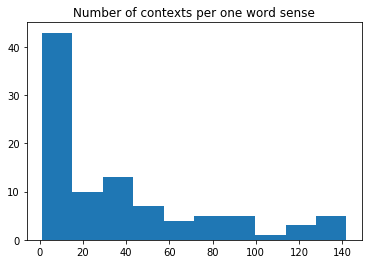

In [56]:
count_per_sense = data.loc[:,['word', 'gold_sense_id', 'context']]\
.groupby(['word', 'gold_sense_id']).['context']

plt.hist(count_per_sense)
plt.title("Number of contexts per one word sense")
plt.show()

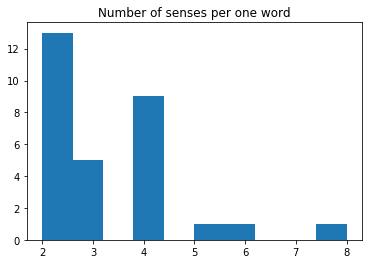

In [225]:
count_senses_per_word = data.loc[:,['word', 'gold_sense_id']]\
.groupby(['word']).nunique()['gold_sense_id']

plt.hist(count_senses_per_word)
plt.title("Number of senses per one word")
plt.show()

# Trivial baselines

In [350]:
!cd .. ; python baseline_trivial.py

Generated oracle baseline dataset: data/main/wiki-wiki/train.oracle.csv
word	ari	count
бор	1.000000	56
замок	1.000000	138
лук	1.000000	110
суда	1.000000	135
	1.000000	439
Generated constant baseline dataset: data/main/wiki-wiki/train.constant.csv
word	ari	count
бор	0.000000	56
замок	0.000000	138
лук	0.000000	110
суда	0.000000	135
	0.000000	439
Generated unique-dataset-wise baseline dataset: data/main/wiki-wiki/train.unique-dataset-wise.csv
word	ari	count
бор	0.000000	56
замок	0.000000	138
лук	0.000000	110
суда	0.000000	135
	0.000000	439
Generated random-1-3 baseline dataset: data/main/wiki-wiki/train.random-1-3.csv
word	ari	count
бор	-0.039401	56
замок	0.019353	138
лук	-0.009793	110
суда	-0.001914	135
	-0.001985	439
Generated random-1-6 baseline dataset: data/main/wiki-wiki/train.random-1-6.csv
word	ari	count
бор	-0.016450	56
замок	0.002059	138
лук	-0.007044	110
суда	-0.007202	135
	-0.005431	439
Generated oracle baseline dataset: data/main/bts-rnc/train.oracle.csv
word	ari	count
балка	

Generated random-1-3 baseline dataset: data/main/active-dict/train.random-1-3.csv
word	ari	count
дар	-0.019114	36
двигатель	-0.078108	15
двойник	-0.036812	25
дворец	0.048780	13
девятка	-0.023559	47
дедушка	-0.084337	9
дежурная	0.101408	12
дежурный	-0.061224	13
декабрист	0.015905	11
декрет	-0.016807	12
дело	0.007592	130
демобилизация	0.280632	14
демократ	-0.041604	18
демонстрация	0.009681	38
дерево	-0.007143	21
держава	0.145078	15
дерзость	-0.028249	37
десятка	0.030163	36
десяток	-0.063868	21
деятель	0.184669	14
диалог	-0.045455	14
диаметр	0.081882	18
диплом	-0.028939	25
директор	0.124668	11
диск	-0.002524	63
дичь	0.027248	18
длина	0.051750	21
доброволец	0.066918	12
добыча	-0.016530	35
доказательство	-0.039458	24
доктор	-0.065313	17
долгота	-0.076768	13
доля	-0.037907	45
дом	0.011495	38
дорога	-0.010455	47
достижение	-0.068726	22
древесина	0.203390	16
дупло	0.134140	15
дура	-0.107176	12
дух	-0.017780	77
дым	-0.054599	28
дымка	-0.039185	18
дыхание	-0.022301	56
дьявол	-0.058606	22
евро	-0

# TF IDF + Clustering baseline

In [246]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import AffinityPropagation

In [247]:
mystem = Mystem()

def lemmatized_context(s, target_word=None):
    # lemmatize all words and words with '-'
    if target_word is None:
        return [w.lower() for w in mystem.lemmatize(s) if re.match('[\w\-]+$', w)]
    else:
        return [w.lower() for w in mystem.lemmatize(s) if\
                (re.match('[\w\-]+$', w) and w.lower()!=target_word)]

In [248]:
words = data.word.unique()
print(words)

['балка' 'вид' 'винт' 'горн' 'губа' 'жаба' 'клетка' 'крыло' 'купюра'
 'курица' 'лавка' 'лайка' 'лев' 'лира' 'мина' 'мишень' 'обед' 'оклад'
 'опушка' 'полис' 'пост' 'поток' 'проказа' 'пропасть' 'проспект' 'пытка'
 'рысь' 'среда' 'хвост' 'штамп']


In [249]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, token_pattern='[\w\-]+$')

# TF-IDF fit all contexts

In [250]:
# contexts with target_word
all_contexts = [" ".join(lemmatized_context(c)) for c in data.context]
all_contexts[0]

'маленький комната он быть очень высокий наклонять голова словно подпирать плечо потолочный балка посмотреть на сьянов серьезный черный глаз я из москва быть испытывать здесь'

In [251]:
# contexts without target_word
contexts_without_tword = np.array([" ".join(lemmatized_context(c,w)) for w,c in zip(data.word, data.context)])
contexts_without_tword[0]

'маленький комната он быть очень высокий наклонять голова словно подпирать плечо потолочный посмотреть на сьянов серьезный черный глаз я из москва быть испытывать здесь'

### tf-idf, contexts without target word

In [369]:
from sklearn.preprocessing import Normalizer

In [108]:
contexts_without_tword_transformed = vectorizer.fit_transform(contexts_without_tword)

In [371]:
normalizer = Normalizer()
contexts_without_tword_transformed = normalizer.fit_transform(contexts_without_tword_transformed)
contexts_without_tword_transformed.shape

(3491, 382)

In [109]:
len(vectorizer.get_feature_names())

382

### Predict fun

In [260]:
def get_labels_for_word(word, all_contexts_vectorized, cluster_model, verbose = False):
    ids = list(data[data.word == word].index)
    X = all_contexts_vectorized[ids]
    golden_labels = data[data.word == word].gold_sense_id
    baseline_labels = data_adagram[data_adagram.word == word].predict_sense_id
    cluster_model.fit(X)
    res_ari =  metrics.adjusted_rand_score(golden_labels, cluster_model.labels_)
    adagram_ari = metrics.adjusted_rand_score(golden_labels, baseline_labels)
    if verbose:
        print('WORD: ', word)
        print("This models ari: ", res_ari)
        print("Adagram models ari: ", adagram_ari)
        print('\n')
    return X, cluster_model.labels_, golden_labels, res_ari, adagram_ari

# DBSCAN

In [255]:
from sklearn.cluster import DBSCAN
from copy import deepcopy

In [269]:
db = DBSCAN(eps=0.9, min_samples=5)
db.get_params()

{'algorithm': 'auto',
 'eps': 0.9,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 5,
 'n_jobs': 1,
 'p': None}

In [271]:
import warnings
warnings.simplefilter('ignore')

In [389]:
def evaluate_ari(clust_model, contexts_without_tword_transformed, name):
    tmp = deepcopy(data)
    res_bs = []
    res_adag = []
    for word in words:
        X, pred_labels, golden_labels, res_ari, adagram_ari = get_labels_for_word(word, contexts_without_tword_transformed, clust_model)
        res_bs.append(res_ari)
        res_adag.append(adagram_ari)
        tmp.loc[tmp.word == word,'predict_sense_id'] = pred_labels
    print(np.mean(res_bs))
    print(np.mean(res_adag))
    if name is not None:
        tmp.to_csv("../tmp_res/{}.csv".format(name), index=False, sep='\t')
    return tmp, np.mean(res_bs)

In [373]:
tmp_db, _ = evaluate_ari(db, contexts_without_tword_transformed=contexts_without_tword_transformed, name='dbscan')

-0.00290472584813
0.233350704958


In [374]:
tmp_db.head()

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,балка,1,-1,90-94,"маленькой комнаты. Он был очень высок, наклони..."
1,2,балка,1,-1,69-73,Пантюхин в Склифе сейчас. Он выползти на улицу...
2,3,балка,1,0,115-121,равнозначно обеспечивает и меланхоличную езду....
3,4,балка,1,1,85-90,"верхняя часть закрыта, замкнута, многократно о..."
4,5,балка,1,-1,66-70,"по телевизору: наши гол забили, я вскочил от р..."


# Visualization

In [375]:
X, pred_labels, golden_labels, _,_ = get_labels_for_word('клетка', contexts_without_tword_transformed, db)
pred_labels

array([-1,  0,  1, -1,  0,  0, -1, -1, -1,  0, -1,  0, -1,  0,  1, -1,  2,
       -1,  0, -1, -1,  0,  0, -1, -1,  2,  2, -1,  0,  0, -1,  1,  0, -1,
        0,  0, -1, -1,  0, -1,  1, -1, -1,  0, -1,  0, -1,  0, -1,  0,  0,
        0, -1,  0,  0, -1, -1, -1,  0, -1, -1,  3, -1,  3, -1,  3,  0, -1,
       -1, -1,  0,  0,  0,  0,  0,  0,  0, -1,  3, -1, -1, -1, -1, -1, -1,
       -1,  0,  0,  1,  0, -1, -1,  0, -1,  0,  0, -1,  0,  0, -1, -1,  0,
        0,  1,  0,  0, -1, -1, -1,  0, -1,  0, -1,  0, -1,  0, -1, -1,  0,
        0, -1,  0,  0, -1,  0, -1, -1, -1,  0, -1, -1, -1, -1,  3,  2, -1,
        0, -1,  0,  0,  0, -1,  0, -1,  2, -1, -1,  0, -1,  0])

(array([ 73.,   0.,  61.,   0.,   0.,   6.,   0.,   5.,   0.,   5.]),
 array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ]),
 <a list of 10 Patch objects>)

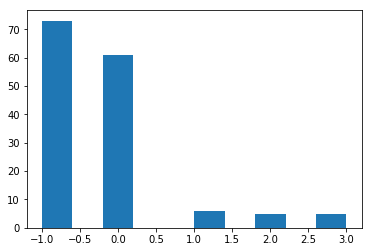

In [376]:
plt.hist(pred_labels)

In [377]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [378]:
def visualize(pred_labels, golden_labels, X):
    pca = PCA(n_components=2, random_state=42)
    viz_x = pca.fit_transform(X.toarray())
    plt.scatter(viz_x[:,0], viz_x[:,1], c=pred_labels, alpha=0.2)
    plt.title("PCA, Predicted labels")
    plt.colorbar()
    plt.show()
    # -----
    plt.scatter(viz_x[:,0], viz_x[:,1], c=golden_labels, alpha=0.2)
    plt.title("PCA, golden labels")
    plt.colorbar()
    plt.show()
    # -----
    tsne = TSNE()
    viz_tsne = tsne.fit_transform(X.toarray())
    plt.scatter(viz_tsne[:,0], viz_tsne[:,1], c=pred_labels, alpha=0.2)
    plt.title("TSNE, Predicted labels")
    plt.colorbar()
    plt.show()
    # -----
    plt.scatter(viz_tsne[:,0], viz_tsne[:,1], c=golden_labels, alpha=0.2)
    plt.title("TSNE, golden labels")
    plt.colorbar()
    plt.show()

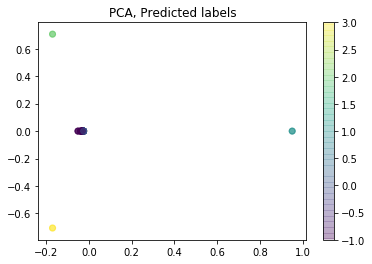

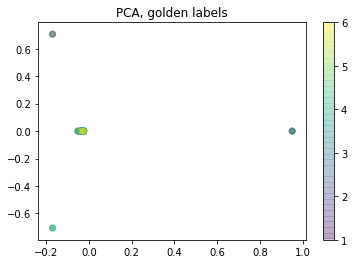

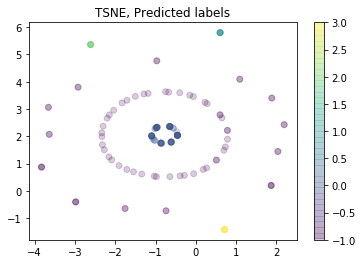

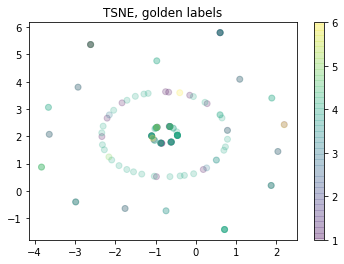

In [379]:
visualize(pred_labels=pred_labels, golden_labels=golden_labels, X=X)

# AffinityPropagation

In [380]:
af = AffinityPropagation(damping=0.7, max_iter=100)

In [381]:
tmp_af, _ = evaluate_ari(af, contexts_without_tword_transformed=contexts_without_tword_transformed, name='aff')

0.00601098979891
0.233350704958


In [382]:
X, pred_labels, golden_labels, _,_ = get_labels_for_word('клетка', contexts_without_tword_transformed, af)
pred_labels

array([  0,   1,  11,   2,   3,   4,   5,  61,  75,   6,   7,   8,   9,
        10,  11,  12, 107,  13,  14,  35,  15,  16,  17, 118,  57, 107,
       107,  87,  18,  19,  20,  11,  21,  22,  23,  24,  52,  25,  26,
        27,  11,  28,  29,  30,  67,  31,  32,  33,  34,  35,  36,  37,
        39,  38,  39,  68,  40,  41,  42,  43,  44, 106, 119, 106,  45,
       106,  46,  47,  16,  48,  49,  50,  51,  52,  53,  54,  55,  56,
       106,  57,  58,  59,  60,  61,  62,  63,  64,  65,  11,  66,  67,
        68,  69,  40,  70,  71,  72,  73,  74,  75,  19,  76,  77,  11,
        78,  79,  80,  81,  82,  83,   1,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109,  30, 110, 111, 112, 113, 114,
       115, 107,  51, 116, 117, 118, 119])

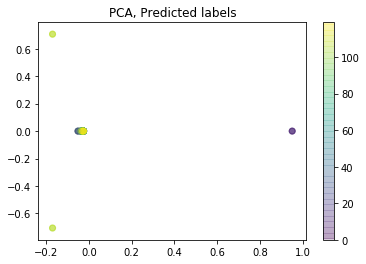

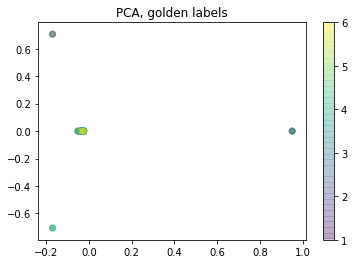

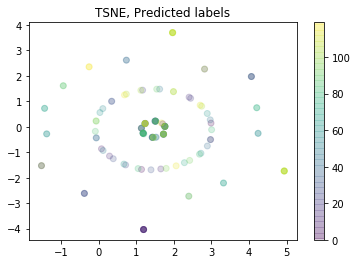

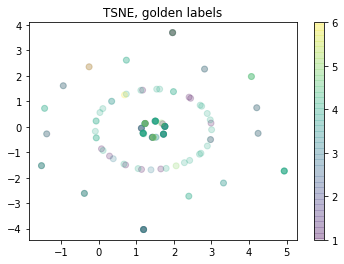

In [383]:
visualize(pred_labels=pred_labels, golden_labels=golden_labels, X=X)

# KMeans

In [384]:
from sklearn.cluster import KMeans

In [385]:
contexts_without_tword_transformed

<3491x382 sparse matrix of type '<class 'numpy.float64'>'
	with 1983 stored elements in Compressed Sparse Row format>

In [397]:
km = KMeans(n_clusters=6, random_state=42)

In [398]:
tmp_ari = evaluate_ari(km, contexts_without_tword_transformed=contexts_without_tword_transformed, name='kmeans6')

0.0187196176586
0.233350704958


In [390]:
max_res = 0
for i in range(1,8):
    km = KMeans(n_clusters=i, random_state=42, )
    print("FOR I=", i)
    _, res = evaluate_ari(km, contexts_without_tword_transformed=contexts_without_tword_transformed, name=None)
    if res>max_res:
        max_res = res
    print('-----\n')

print(max_res)

FOR I= 1
0.0
0.233350704958
-----

FOR I= 2
0.00897191829598
0.233350704958
-----

FOR I= 3
0.00649405031318
0.233350704958
-----

FOR I= 4
0.011313112732
0.233350704958
-----

FOR I= 5
0.00855929003116
0.233350704958
-----

FOR I= 6
0.0187196176586
0.233350704958
-----

FOR I= 7
0.00563930540936
0.233350704958
-----

0.0187196176586


In [344]:
km = KMeans(n_clusters=6, random_state=42)

In [346]:
X, pred_labels, golden_labels, _, _ = get_labels_for_word('поток', contexts_without_tword_transformed, km)
pred_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 5, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0,
       0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 4, 0, 0], dtype=int32)

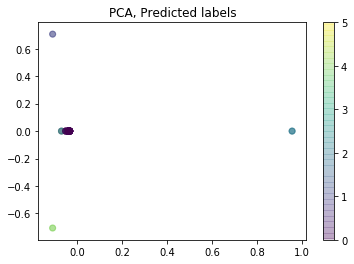

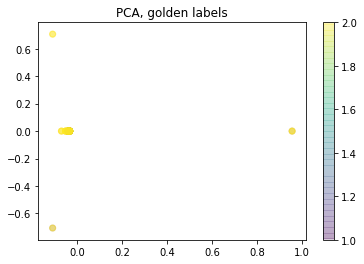

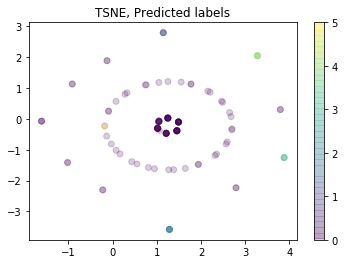

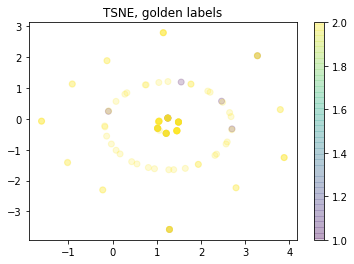

In [347]:
visualize(pred_labels=pred_labels, golden_labels=golden_labels, X=X)

## Alternative metrics currently drafted

In [ ]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

# Evaluation

### baseline evaluation

In [365]:
!python3 ../evaluate.py ../tmp_res/aff.csv

word	ari	count
балка	0.000460	119
вид	-0.001822	77
винт	-0.001720	123
горн	0.000684	51
губа	0.000647	137
жаба	-0.004379	121
клетка	-0.001753	150
крыло	0.003432	91
купюра	-0.000156	150
курица	-0.000554	93
лавка	-0.000390	149
лайка	0.000010	99
лев	0.014976	44
лира	0.096036	49
мина	0.071851	65
мишень	-0.001195	121
обед	0.006447	100
оклад	-0.000321	146
опушка	0.000506	148
полис	0.000331	142
пост	0.000226	144
поток	-0.000825	136
проказа	0.001048	146
пропасть	-0.002198	127
проспект	0.000925	139
пытка	-0.000800	143
рысь	-0.000958	120
среда	0.002709	144
хвост	-0.002701	121
штамп	-0.000186	96
	0.002739	3491


In [366]:
!python3 ../evaluate.py ../tmp_res/dbscan.csv

word	ari	count
балка	-0.014968	119
вид	-0.017563	77
винт	0.010895	123
горн	-0.019937	51
губа	-0.007906	137
жаба	0.011138	121
клетка	0.015442	150
крыло	-0.008823	91
купюра	-0.003993	150
курица	-0.010609	93
лавка	-0.002383	149
лайка	0.032303	99
лев	-0.019638	44
лира	0.031621	49
мина	0.008277	65
мишень	0.001876	121
обед	-0.040902	100
оклад	0.002054	146
опушка	-0.017183	148
полис	0.000773	142
пост	-0.022061	144
поток	0.007281	136
проказа	-0.012660	146
пропасть	0.012978	127
проспект	-0.052361	139
пытка	0.031771	143
рысь	-0.009885	120
среда	-0.013286	144
хвост	0.031685	121
штамп	-0.011078	96
	-0.002864	3491


In [399]:
!python3 ../evaluate.py ../tmp_res/kmeans6.csv

word	ari	count
балка	-0.009493	119
вид	-0.027491	77
винт	0.002676	123
горн	-0.024159	51
губа	-0.055757	137
жаба	0.054312	121
клетка	0.040454	150
крыло	0.020045	91
купюра	0.055818	150
курица	0.037382	93
лавка	0.000154	149
лайка	-0.055560	99
лев	0.244401	44
лира	0.043842	49
мина	0.237745	65
мишень	0.015091	121
обед	0.059183	100
оклад	-0.020392	146
опушка	-0.058911	148
полис	-0.034279	142
пост	0.008157	144
поток	0.023802	136
проказа	-0.044827	146
пропасть	0.068304	127
проспект	-0.016195	139
пытка	0.048207	143
рысь	-0.048971	120
среда	-0.013871	144
хвост	0.036453	121
штамп	-0.024531	96
	0.009725	3491
